# Imports

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import get_data, standarize_data
from oja import OjaNetwork

# PCA - Sklearn
## Biplot para las componentes principales 1 y 2

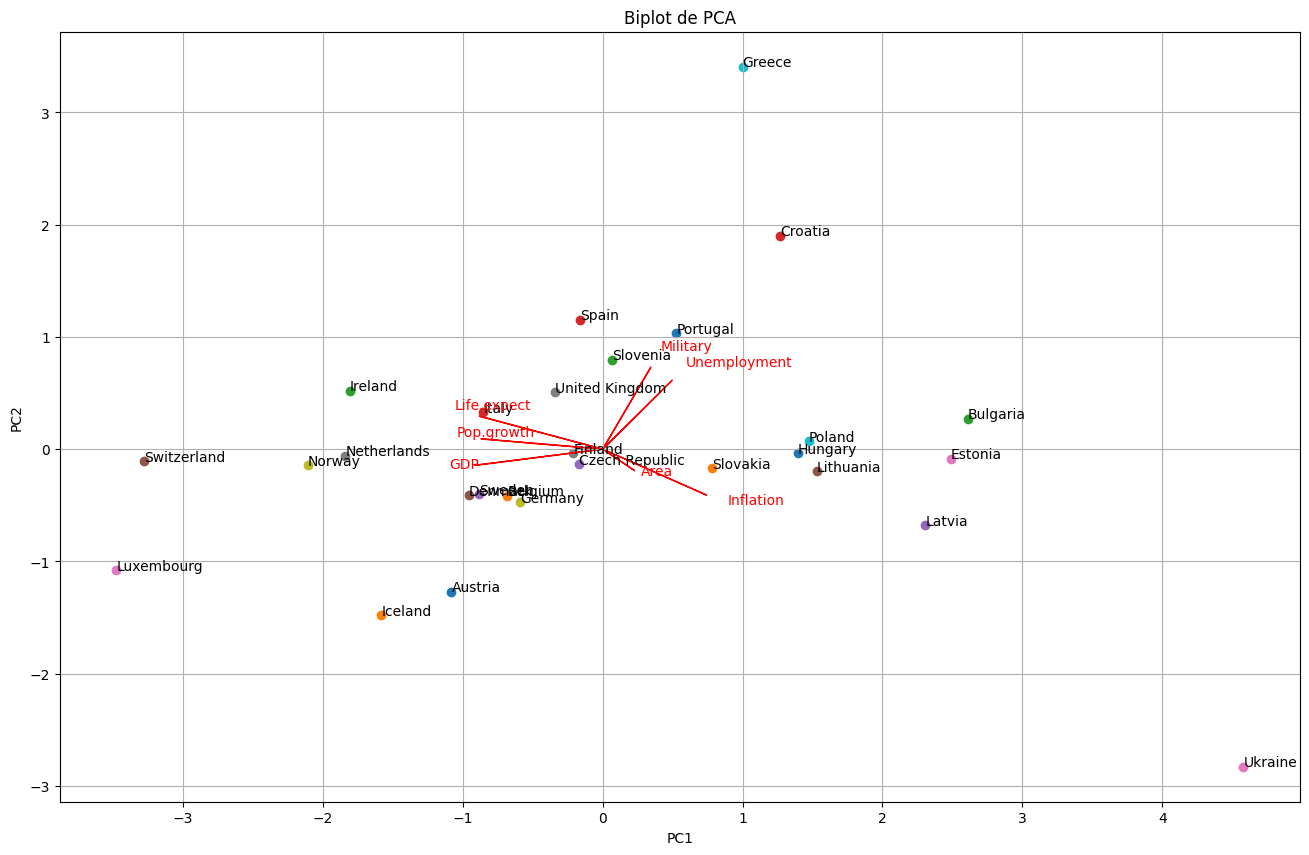

In [8]:
# Leemos los datos
data = pd.read_csv("../data/europe.csv")
components = list(data.columns)[1:]

# Extraer los nombres de los países y almacenarlos en una variable
countries = data["Country"]
data = data.drop(columns=["Country"])  # Eliminar la columna de nombres de los países

# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Ajustar un modelo de PCA con dos componentes principales
pca = PCA() # n_components=2
principal_components = pca.fit_transform(data_scaled)

# Obtenemos las cargas de las componentes principales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear un DataFrame con los resultados del PCA
principal_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"])

# Crear el gráfico de biplot con los nombres de los países
fig, ax = plt.subplots(figsize=(16, 10))  # Aumentar el tamaño del gráfico

for i, country in enumerate(countries):
    x = principal_df.loc[i, "PC1"]
    y = principal_df.loc[i, "PC2"]
    ax.scatter(x, y)
    ax.annotate(country, (x, y))

# Graficar los vectores de las componentes
for i in range(len(principal_components[0])):
        ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0, head_length=0, fc='red', ec='red')
        ax.text(loadings[i, 0]*1.2, loadings[i, 1]*1.2, f'{components[i]}', color='red')


# Configurar el gráfico
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Biplot de PCA")

plt.grid()
plt.show()

## Gráfico de barras para la componente principal 1 según el país

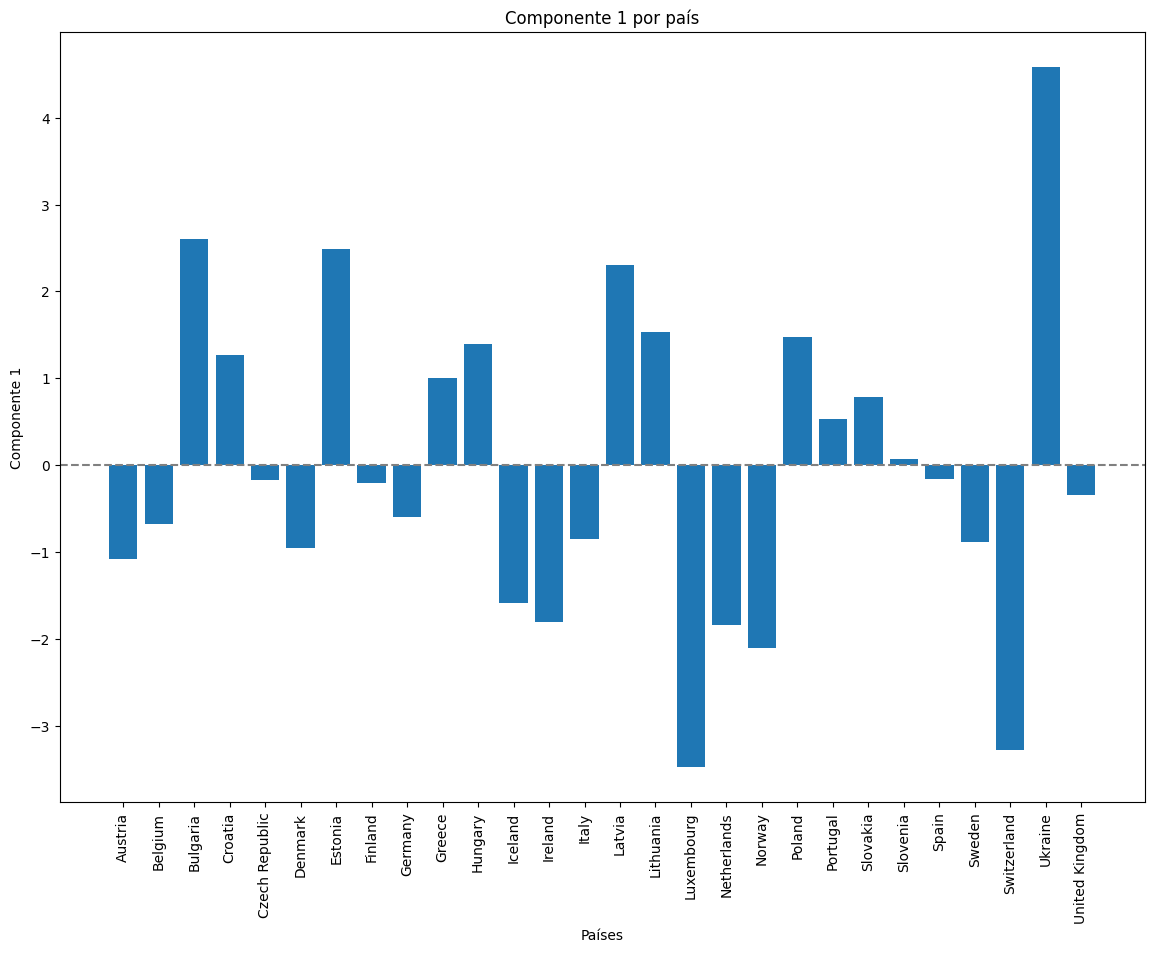

In [11]:
# Leemos los datos
data = pd.read_csv("../data/europe.csv")

# Extraer los nombres de los países y almacenarlos en una variable
countries = data["Country"]
data = data.drop(columns=["Country"])  # Eliminar la columna de nombres de los países

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=1)
principal_components = pca.fit_transform(data_scaled)
pca_vector = pca.components_.T[:, 0]

# colors = ['green' if value > 0 else 'red' for value in principal_df["Componente 1"]]

principal_df = pd.DataFrame(data=principal_components, columns=["Componente 1"])

fig, ax = plt.subplots(figsize=(14, 10))

ax.bar(countries, principal_df["Componente 1"])

ax.axhline(y=0, color='gray', linestyle='--')
ax.set_ylabel("Componente 1")
ax.set_xlabel("Países")
ax.set_title("Componente 1 por país")

plt.xticks(rotation='vertical')
plt.show()

In [12]:
print("Vector de Cargas PC1 - Sklearn")
data = {'': np.round(list(pca_vector),5)}
df = pd.DataFrame(data, index=['Area', 'GDP', 'Inflation', 'Life.expect', 'Military', 'Pop.growth', 'Unemployment']).transpose().applymap(lambda x: f'{x:.4f}')
df

Vector de Cargas PC1 - Sklearn


,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
,0.1249,-0.5005,0.4065,-0.4829,0.1881,-0.4757,0.2717


# Oja Network

In [47]:
config = {
    "learning_rate": 0.001,
    "max_epochs": 100000
}

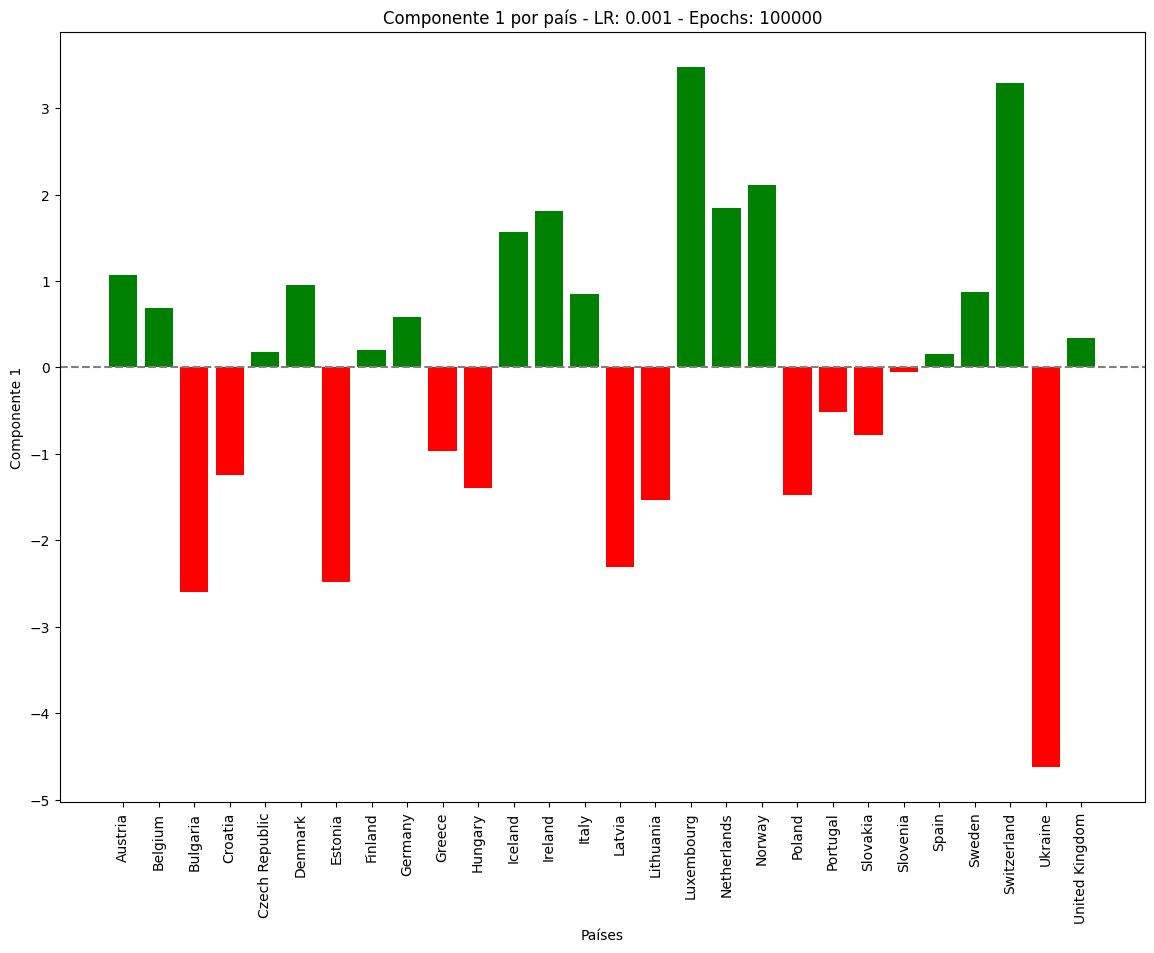

In [45]:
learning_rate = config["learning_rate"] 
max_epochs = config["max_epochs"]

countries, labels, data = get_data()

standarized_data = standarize_data(data)

oja = OjaNetwork(learning_rate, len(standarized_data[0]))

weights = oja.train(standarized_data, max_epochs)

pca = np.matmul(standarized_data, weights)

principal_df = pd.DataFrame(data=pca, columns=["Componente 1"])

fig, ax = plt.subplots(figsize=(14, 10))

colors = ['green' if value > 0 else 'red' for value in pca]

ax.bar(countries, principal_df["Componente 1"], color=colors)

ax.axhline(y=0, color='gray', linestyle='--')
ax.set_ylabel("Componente 1")
ax.set_xlabel("Países")
ax.set_title(f"Componente 1 por país - LR: {learning_rate} - Epochs: {max_epochs}")

plt.xticks(rotation='vertical')
plt.show()

In [17]:
print("Vector de Cargas PC1 - Oja")
data = {'': np.round(list(weights),5)}
df = pd.DataFrame(data, index=labels).transpose().applymap(lambda x: f'{x:.4f}')
df

Vector de Cargas PC1 - Oja


,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
,-0.1321,0.4998,-0.4136,0.4844,-0.1822,0.4742,-0.2681


### Modificamos los diferentes parametros de la red para ver como esto afecta al resultado

Veamos como afecta la cantidad de epocas que dejamos entrenar al algoritmo analizando el error en función de las epocas.

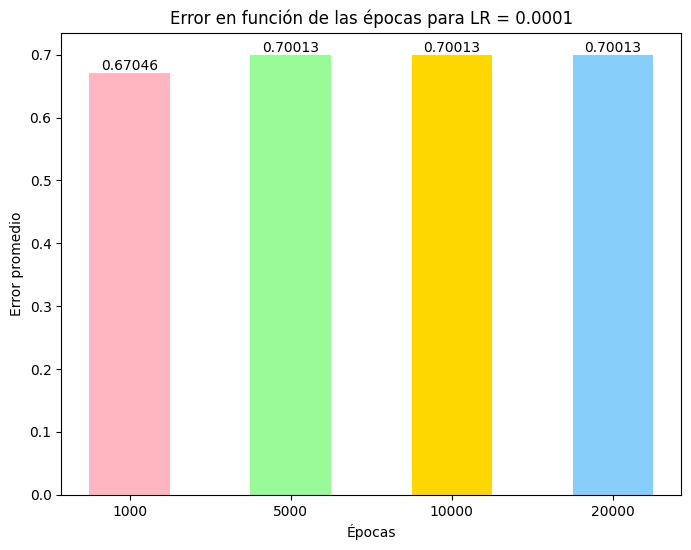

In [37]:
max_epochs = [1000, 5000, 10000, 20000]
learning_rate = 0.0001

errors = []

for epochs in max_epochs:
    oja = OjaNetwork(learning_rate, len(standarized_data[0]))
    weights = oja.train(standarized_data, epochs)

    error = np.average(np.abs(pca_vector - weights))
    errors.append(error)

    # print(f"Learning Rate: {learning_rate} - Epochs: {epochs}")
    # print(f"PC1 - Sklearn\n{pca_vector}")
    # print(f"PC1 - Oja\n{weights}")
    # print(f"Average Error: {error}\n")


# Plot
colors = ['#FFB6C1', '#98FB98', '#FFD700', '#87CEFA']
bar_width = 0.5
x = range(len(errors))

plt.figure(figsize=(8,6))
bars = plt.bar(x, errors, bar_width, color=colors, capsize=5)

for bar, error in zip(bars, errors):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{error:.5f}', ha='center', va='bottom')

plt.xticks(x, max_epochs)
plt.xlabel('Épocas')
plt.ylabel('Error promedio')
plt.title('Error en función de las épocas para LR = 0.0001')
plt.show()


Ahora veamos como afecta el learning rate de la red.

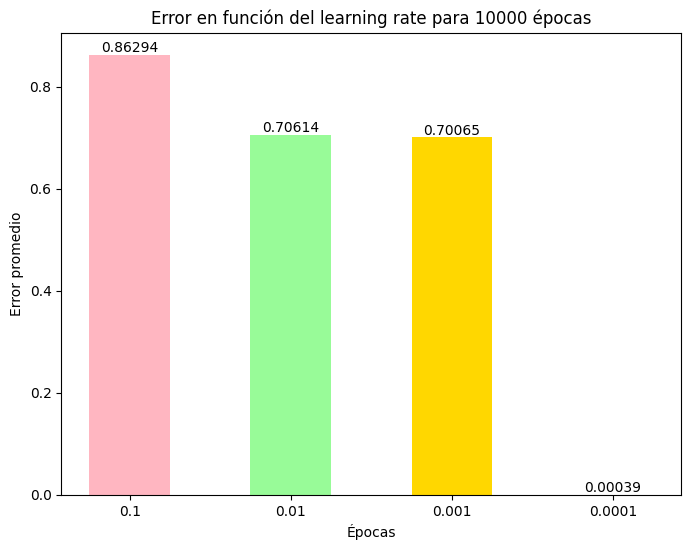

In [35]:
max_epochs = 10000
learning_rates = [0.1, 0.01, 0.001, 0.0001]

errors = []

for lr in learning_rates:
    oja = OjaNetwork(lr, len(standarized_data[0]))
    weights = oja.train(standarized_data, max_epochs)

    error = np.average(np.abs(pca_vector - weights))
    errors.append(error)


# Plot
colors = ['#FFB6C1', '#98FB98', '#FFD700', '#87CEFA']
bar_width = 0.5
x = range(len(errors))

plt.figure(figsize=(8,6))
bars = plt.bar(x, errors, bar_width, color=colors, capsize=5)

for bar, error in zip(bars, errors):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{error:.5f}', ha='center', va='bottom')

plt.xticks(x, learning_rates)
plt.xlabel('Épocas')
plt.ylabel('Error promedio')
plt.title('Error en función del learning rate para 10000 épocas')
plt.show()